# Lambda Learner for Incremental Learning using GLMix models

***A framework for incremental learning for personalization at scale.***

Lambda Learner is a framework to incrementally train the memorization part of the model as a booster over the generalization part. We incrementally update the memorization model between full batch offline updates of the generalization model to balance training performance against model stability.

The key concept is to prepare mini-batches of data from an incoming stream of logged data to train an incremental update to the memorization model. We approximate the loss function on previously observed data by a local quadratic approximation around the previous optimal value and combine it with the loss function on the most recent mini-batch. This allows us to incrementally update the model without relying on all historical data yet do better than just relying on the new incoming data. This results in a regularized learning problem with a weighted penalty. In the Bayesian interpretation, the local quadratic approximation is equivalent to using the posterior distribution of the previous model as prior for training the update.

---

Lambda Learner is a library for iterative incremental training of a class of supervised machine learning models. Using the Generalized Additive Mixed-Effect (GAME) framework, one can divide a model into two components, (a) Fixed Effects - a typically large "fixed effects" model (generalization) that is trained on the whole dataset to improve the model’s performance on previously unseen user-item pairs, and (b) Random Effects - a series of simpler linear "random-effects" models (memorization) trained on data corresponding to each entity (e.g. user or article or ad) for more granular personalization.

The two main choices in defining a GAME architecture are 1) choosing the model class for the fixed effects model, and 2) choosing which random effects to include. The fixed effects model can be of any model class, typically Tensorflow, DeText, GDMix, XGBoost. As for the random effects, this choice is framed by your training data; specifically by the keys/ids of your training examples. If your training examples are keyed by a single id space (say userId), then you will have one series of random effects keyed by userId (per-user random effects). If your data is keyed by multiple id spaces (say userId, movieId), then you can have up to one series of random effects for every id type (per-user random effects, and per-movie random effects). However it's not necessary to have random effects for all ids, with the choice being largely a modeling concern.

Lambda Learner currently supports using any fixed-effects model, but only random effects for a single id type.

Bringing these two pieces together, the residual score from the fixed effects model is improved using a random effect linear model, with the global model's output score acting as the bias/offset for the linear model. Once the fixed effects model has been trained, the training of random effects can occur independently and in parallel. The library supports incremental updates to the random effects components of a GAME model in response to mini-batches from data streams. Currently the following algorithms for updating a random effect are supported:

- Linear regression.
- Logistic regression.
- Sequential Bayesian logistic regression (as described in the [Lambda Learner paper](https://arxiv.org/abs/2010.05154)).

The library supports maintaining a model coefficient Hessian matrix, representing uncertainty about model coefficient values, in addition to point estimates of the coefficients. This allows us to use the random effects as a multi-armed bandit using techniques such as Thompson Sampling.

One of the most well-established applications of machine learning is in deciding what content to show website visitors. When observation data comes from high-velocity, user-generated data streams, machine learning methods perform a balancing act between model complexity, training time, and computational costs. Furthermore, when model freshness is critical, the training of models becomes time-constrained. Parallelized batch offline training, although horizontally scalable, is often not time-considerate or cost effective.

Lambda Learner is capable of incrementally training the memorization part of the model (the random-effects components) as a performance booster over the generalization part. The frequent updates to these booster models over already powerful fixed-effect models improve personalization. Additionally, it allows for applications that require online bandits that are updated quickly.

[Lambda Learner: Nearline learning on data streams](https://engineering.linkedin.com/blog/2021/lambda-learner--nearline-learning-on-data-streams)

In the GAME paradigm, random effects components can be trained independently of each other. This means that their update can be easily parallelized across nodes in a distributed computation framework. For example, this library can be used on top of Python Beam or PySpark. The distributed compute framework is used for parallelization and data orchestration, while the Lambda Learner library implements the update of random effects in individual compute tasks (DoFns in Beam or Task closures in PySpark).

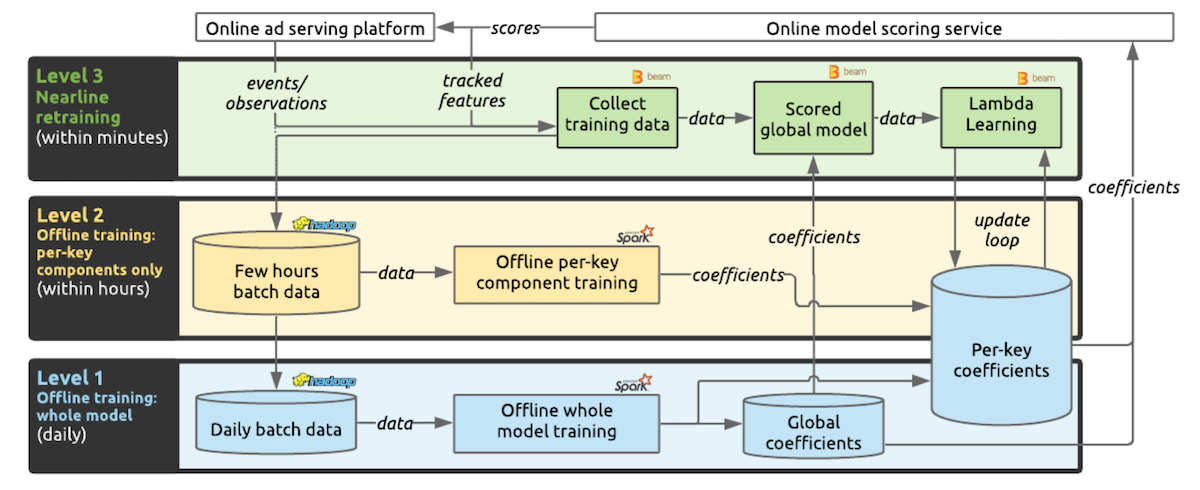

## Setup

In [ ]:
!pip install lambda-learner

In [5]:
!wget -q --show-progress https://github.com/linkedin/lambda-learner/raw/main/test/resource/mock-ntv-data-1k.json
!wget -q --show-progress https://github.com/linkedin/lambda-learner/raw/main/test/resource/movie-lense-training-data-u359
!wget -q --show-progress https://github.com/linkedin/lambda-learner/raw/main/test/resource/movie-lense-test-data-u359
!wget -q --show-progress https://github.com/linkedin/lambda-learner/raw/main/test/resource/movie-lense-initital-fixed-effect-model
!wget -q --show-progress https://github.com/linkedin/lambda-learner/raw/main/test/resource/movie-lense-final-model-u359

mock-ntv-data-1k.js 100%[===================>] 357.45K  --.-KB/s    in 0.03s   
movie-lense-trainin 100%[===================>] 642.10K  --.-KB/s    in 0.04s   
movie-lense-test-da 100%[===================>]  86.28K  --.-KB/s    in 0.01s   
movie-lense-initita 100%[===================>]     383  --.-KB/s    in 0s      
movie-lense-final-m 100%[===================>]     624  --.-KB/s    in 0s      


In [40]:
import json
import os
import pathlib
from typing import Any, Dict, List

import numpy as np
from scipy import sparse
from itertools import permutations

from linkedin.learner.ds.feature import Feature
from linkedin.learner.ds.indexed_dataset import IndexedDataset
from linkedin.learner.ds.record import TrainingRecord
from linkedin.learner.ds.indexed_model import IndexedModel
from linkedin.learner.prediction.linear_scorer import score_linear_model
from linkedin.learner.utils.functions import sparse_diag_matrix
from linkedin.learner.ds.index_map import IndexMap
from linkedin.learner.prediction.evaluator import evaluate
from linkedin.learner.prediction.hessian_type import HessianType
from linkedin.learner.prediction.trainer_square_loss_with_l2 import TrainerSquareLossWithL2
from linkedin.learner.prediction.trainer_logistic_loss_with_l2 import TrainerLogisticLossWithL2
from linkedin.learner.prediction.trainer_sequential_bayesian_logistic_loss_with_l2 import \
    TrainerSequentialBayesianLogisticLossWithL2
from linkedin.learner.ds.representation_utils import (
    index_domain_coeffs_to_nt_domain_coeffs,
    nt_domain_coeffs_to_index_domain_coeffs,
    nt_domain_data_to_index_domain_data)

import unittest

In [7]:
MOCK_NTV_DATASET_PATH = "mock-ntv-data-1k.json"
MOVIE_LENS_TRAINING_DATA_PATH = "movie-lense-training-data-u359"
MOVIE_LENS_TEST_DATA_PATH = "movie-lense-test-data-u359"
MOVIE_LENS_INITIAL_MODEL_PATH = "movie-lense-initital-fixed-effect-model"
MOVIE_LENS_EXPECTED_TRAINED_MODEL_PATH = "movie-lense-final-model-u359"

In [8]:
OFFLINE_RESPONSE = "label"
WEIGHT = "weight"
FEATURES = "features"
OFFSET = "offset"

In [9]:
# Features are logged as name, term, value
FEATURE_NAME = "name"
FEATURE_TERM = "term"
FEATURE_VALUE = "value"

In [17]:
# How precise to make "almost equal" comparisons
PLACES_PRECISION = 8
RELATIVE_PRECISION = 10e-6

## Utils

In [18]:
def sequences_almost_equal(a, b, rel_precision: float = RELATIVE_PRECISION):
    """Test whether two sequences are uniformly pointwise different by at most a given factor.
    This is a test helper intended to be used with [[assertTrue]] in a [[unittest.TestCase]]
    """
    a_ndarray = np.array(a)
    b_ndarray = np.array(b)
    zero_adjustment = ((b_ndarray == 0) + 0) * (rel_precision / 1000)
    return all((abs(1 - (a_ndarray + zero_adjustment) / (b_ndarray + zero_adjustment)) < rel_precision).flatten())


def matrices_almost_equal(a, b, rel_precision: float = RELATIVE_PRECISION):
    """Test whether two matrices are uniformly pointwise different by at most a given factor.
    This is a test helper intended to be used with [[assertTrue]] in a [[unittest.TestCase]]
    """
    zero_adjustment = ((b == 0) + 0) * (rel_precision / 1000)
    return all((np.array(abs(1 - (a + zero_adjustment) / (b + zero_adjustment)) < rel_precision)).flatten())


def ensure_str(bytes_or_str, encoding: str = "utf-8"):
    """
    Ensures that an object which is either a string or bytes is treated as a string.
    """
    return str(bytes_or_str, encoding) if isinstance(bytes_or_str, bytes) else bytes_or_str

In [10]:
def read_ntv_records_from_json(num_examples: int = -1, data_path=MOCK_NTV_DATASET_PATH):
    """Read records from a file with one ntv json-formatted record per line.
    :param num_examples: How many records to load? -1 means no limit.
    :param data_path: Path to data file.
    :return: List of loaded records.
    """
    with open(data_path, "rb") as file:
        if num_examples > 0:
            records = [json.loads(next(file)) for _ in range(num_examples)]
        else:
            records = [json.loads(line) for line in file]
    return records

In [11]:
def read_model(file):
    """Read an index-domain model file with one coefficient per line.
    :param file: Path to model file.
    :returns: NDArray of coefficients.
    """
    with open(file, "r") as file:
        theta = [float(line) for line in file.readlines()]
    return np.array(theta)

In [12]:
def read_tsv_data(file):
    """"Read a tab-separated value file of index-domain data, with one record per line.
    :param file: Path to data file.
    :returns: IndexedDataset representing the loaded data.
    """
    with open(file, "r") as file:
        example_list = [line.split("\t") for line in file.readlines()]
        num_examples = len(example_list)

        labels = []
        values = []
        cols = []
        rows = []
        offsets = [0] * num_examples  # temporary value
        weights = [1] * num_examples

        for idx, example in enumerate(example_list):
            timestamp, y, *feature_values = example
            timestamp = int(timestamp)
            y = float(y)
            feature_values = [float(v) for v in feature_values]

            # Add intercept
            values.append(1.0)
            cols.append(0)
            rows.append(idx)

            num_features = len(feature_values)
            feature_idx = range(1, num_features + 1)

            # Add other features
            values.extend(feature_values)
            cols.extend(feature_idx)
            rows.extend([idx] * num_features)

            labels.append(y)

        data = sparse.coo_matrix((values, (rows, cols)), shape=(num_examples, 1 + num_features), dtype=np.float64).tocsc()

        offsets = np.array(offsets, dtype=np.float64)
        weights = np.array(weights, dtype=np.float64)
        labels = np.array(labels)

    return IndexedDataset(data, labels, weights, offsets)

In [13]:
def read_movie_lens_data():
    """Read the movie lens data for testing.
    :returns: Movie Lens training and test datasets.
    """
    theta = read_model(MOVIE_LENS_INITIAL_MODEL_PATH)
    training_data = read_tsv_data(MOVIE_LENS_TRAINING_DATA_PATH)
    test_data = read_tsv_data(MOVIE_LENS_TEST_DATA_PATH)

    training_data.offsets = training_data.X * theta
    test_data.offsets = test_data.X * theta

    return training_data, test_data

In [14]:
def read_expected_movie_lens_training_result():
    """Read the expected movie lens training result (the trained model).
    :returns: NDArray representing the loaded model.
    """
    return read_model(MOVIE_LENS_EXPECTED_TRAINED_MODEL_PATH)

In [15]:
def features_from_json(features_json: List[Any], feature_name_translation_map: Dict[str, str] = None) -> List[Feature]:
    """Convert a bag of json-like features to Feature format.
    :param features_json: A list of features as parsed directly from json.
    :param feature_name_translation_map: (Optional) Mapping for using different names internally.
    :return: A list of Features.
    """
    feature_list = []
    for feature in features_json:
        name, term, value = feature[FEATURE_NAME], feature[FEATURE_TERM], feature[FEATURE_VALUE]
        if not feature_name_translation_map:
            # use all features as they are
            feature_list.append(Feature(name, term, value))
        elif name in feature_name_translation_map:
            # use a subset of features, possibly translated to a different name
            # otherwise we drop this feature and don't use it in retraining
            translated_feature_name = feature_name_translation_map[name]
            feature_list.append(Feature(translated_feature_name, term, value))
    return feature_list

In [16]:
def training_record_from_json(record_json) -> TrainingRecord:
    """Convert a json-like record in TrainingRecord format.
    :param record_json: A record as parsed directly from json.
    :return: A TrainingRecord object.
    """
    features_json = record_json[FEATURES]
    features = features_from_json(features_json)
    return TrainingRecord(label=record_json[OFFLINE_RESPONSE], weight=record_json[WEIGHT], offset=record_json[OFFSET], features=features)

In [22]:
def generate_mock_training_data(num_examples: int = -1):
    """Load large mock data and index it.
    :param num_examples: How many examples to load.
    :returns: A tuple of IndexedDataset, IndexMap
    """
    raw_data = [training_record_from_json(_) for _ in read_ntv_records_from_json(num_examples)]
    imap, _ = IndexMap.from_records_means_and_variances(raw_data, [], [])
    indexed_data = nt_domain_data_to_index_domain_data(raw_data, imap)
    return indexed_data, imap


def simple_mock_data():
    """Load a very small mock dataset.
    :returns: A tuple of IndexedDataset, IndexedModel
    """
    row = np.array([0, 0, 0, 1, 1, 1])
    col = np.array([0, 1, 2, 0, 1, 2])
    data = np.array([1, 0.5, 3, 0.5, 0, 1.0])
    X = sparse.coo_matrix((data, (row, col)), shape=(2, 3), dtype=np.float64)
    y = np.array([-1.0, 1.0])
    offsets = np.array([-0.25, 1.0])
    w = np.array([1.0, 1.0])
    indexed_data = IndexedDataset(X, y, w, offsets)

    theta = np.array([0.25, 0.75, -1.5])
    model = IndexedModel(theta=theta, hessian=sparse_diag_matrix([1, 1, 1]))

    return indexed_data, model

## Linear Scorer

In [20]:
def mock_indexed_data():
    """Get a very small mock indexed dataset."""
    labels = np.array([1.0, -1.0, 1.0])
    weights = np.array([1, 1, 1])
    offsets = np.array([0.2, 0.3, 0.4])
    design_matrix = sparse.csc_matrix(np.array([[1.0, 1.0, 0, 0, 0, 0, 0], [1.0, 0, 0, 0, 0, 0, 0], [1.0, 0, 0, 0.5, 1.0, 1.3, 0.8]]))
    return IndexedDataset(design_matrix, labels, weights, offsets)


class LinearScorerTest(unittest.TestCase):
    def test_score_linear_model(self):
        """Test linear scoring in the general case."""
        theta = np.array([1.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
        hessian = sparse_diag_matrix([2.0, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6])
        indexed_model = IndexedModel(theta, hessian)

        indexed_data = mock_indexed_data()

        scores = score_linear_model(indexed_model, indexed_data)

        expected_scores = np.array(
            [0.2 + 1.0 * 1.0 + 1.0 * 0.1, 0.3 + 1.0 * 1.0, 0.4 + 1.0 * 1.0 + 0.5 * 0.3 + 1.0 * 0.4 + 1.3 * 0.5 + 0.8 * 0.6]
        )

        self.assertTrue(all(scores == expected_scores), f"Scores match expected scores. Actual {scores} == expected {expected_scores}.")

        scores_with_exploration = score_linear_model(indexed_model, indexed_data, exploration_threshold=1)

        self.assertTrue(
            all(scores_with_exploration != expected_scores),
            f"Scores with exploration don't exactly match expected scores. Actual {scores} == expected {expected_scores}.",
        )

    def test_score_linear_model_offsets_only(self):
        """Test linear scoring when all coefficients are zero."""
        num_features = 7
        theta = np.zeros(num_features)
        indexed_model = IndexedModel(theta)
        indexed_data = mock_indexed_data()

        scores = score_linear_model(indexed_model, indexed_data)

        expected_scores = np.array([0.2, 0.3, 0.4])

        self.assertTrue(
            all(scores == expected_scores),
            f"Offsets are used for scores when model coeffs are all zero/missing. Actual {scores} == expected {expected_scores}.",
        )

## Trainers

In [29]:
class TrainerSquareLossWithL2Test(unittest.TestCase):
    def test_square_loss_with_l2_loss_and_gradient(self):
        """Test the loss and gradient functions.
        The expected values in this test are set using this implementation, so this
        is a test against regression, rather than strictly a test of correctness.
        """
        training_data, test_data = read_movie_lens_data()

        theta_0 = np.zeros(training_data.num_features)
        initial_model = IndexedModel(theta=theta_0)

        trainer = TrainerSquareLossWithL2(training_data=training_data, initial_model=initial_model, penalty=10)
        final_model, final_loss, metadata = trainer.train(precision=1e4, num_corrections=7, max_iterations=50)

        actual_scores = score_linear_model(model=final_model, test_data=test_data)
        final_rmse = evaluate(metric_list=["rmse"], y_scores=actual_scores, y_targets=test_data.y)["rmse"]

        expected_theta = read_expected_movie_lens_training_result()
        expected_model = IndexedModel(theta=expected_theta)
        expected_scores = score_linear_model(expected_model, test_data)
        expected_rmse = evaluate(metric_list=["rmse"], y_scores=expected_scores, y_targets=test_data.y)["rmse"]

        self.assertAlmostEqual(expected_rmse, final_rmse)

        self.assertTrue(
            sequences_almost_equal(expected_theta, final_model.theta),
            f"Theta as expected: Expected = {expected_theta}, Actual = {final_model.theta}",
        )

    def test_square_loss_with_l2_update_hessian(self):
        """Test the Hessian update."""
        indexed_data, model = simple_mock_data()

        lr = TrainerSquareLossWithL2(training_data=indexed_data, initial_model=model, penalty=10, hessian_type=HessianType.FULL)
        hessian = lr._update_full_hessian(model.theta)

        expected_hessian = np.array(
            [
                [0.0760066037, 0.00782668920, 0.1676665858],
                [0.00782668920, 0.00391334460, 0.02348006762],
                [0.1676665858, 0.02348006762, 0.382293306],
            ]
        )

        self.assertTrue(
            matrices_almost_equal(hessian, expected_hessian),
            f"Hessian computation is correct. Actual {hessian} == Expected {expected_hessian}.",
        )

In [30]:
class TrainerLogisticLossWithL2Test(unittest.TestCase):
    def test_lr_loss_and_gradient(self):
        """Test the loss and gradient functions.
        The expected values in this test are set using this implementation, so this
        is a test against regression, rather than strictly a test of correctness.
        """
        indexed_data, _ = generate_mock_training_data()

        theta_0 = np.array([4, 100, 1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float64)
        initial_model = IndexedModel(theta=theta_0)

        lr = TrainerLogisticLossWithL2(training_data=indexed_data, initial_model=initial_model, penalty=10)
        initial_loss = lr.loss(theta_0)

        self.assertAlmostEqual(initial_loss, 153042.61089443817, PLACES_PRECISION, "Expect loss is calculated correctly.")

        initial_gradient = lr.gradient(theta_0)

        self.assertTrue(
            sequences_almost_equal(initial_gradient, [1038.0, 1998.0, 879.0, 879.0, 1008.0, 1008.0, 134.0, 134.0, 15.0, 15.0]),
            "Expect gradient is calculated correctly.",
        )

        final_model, final_loss, metadata = lr.train()

        self.assertTrue(
            sequences_almost_equal(
                final_model.theta,
                [
                    -0.14982811627991494,
                    -0.14982824552049578,
                    -0.19636393879356379,
                    -0.19636393879356379,
                    -0.1498281122411468,
                    -0.1498281122411468,
                    0.04935191200563128,
                    0.04935191200563128,
                    -0.0028160881457262527,
                    -0.0028160881457262527,
                ],
            ),
            "Expect theta after optimization is correct.",
        )
        self.assertAlmostEqual(final_loss, 15.666764037573559, PLACES_PRECISION, "Expect lost after optimization is correct.")
        self.assertEqual(metadata["warnflag"], 0, "Expect convergence status is 0, meaning successful convergence.")
        self.assertEqual(metadata["nit"], 13, "Expect number of iterations is correct.")
        self.assertEqual(metadata["funcalls"], 18, "Expect number of function calls is correct.")
        self.assertEqual(ensure_str(metadata["task"]), "CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL", f"Expect convergence reason is as expected")

        # Score (on the training data)
        initial_scores = score_linear_model(model=initial_model, test_data=indexed_data)
        initial_auc = evaluate(metric_list=["auc"], y_scores=initial_scores, y_targets=indexed_data.y)["auc"]
        final_scores = score_linear_model(model=final_model, test_data=indexed_data)
        final_auc = evaluate(metric_list=["auc"], y_scores=final_scores, y_targets=indexed_data.y)["auc"]

        expected_initial_auc = 0.5290581162324649
        expected_final_auc = 0.6137274549098197

        self.assertAlmostEqual(
            initial_auc, expected_initial_auc, PLACES_PRECISION, f"Initial AUC: expected {expected_initial_auc} == actual {initial_auc}"
        )
        self.assertAlmostEqual(
            final_auc, expected_final_auc, PLACES_PRECISION, f"Final AUC: expected {expected_final_auc} == actual {final_auc}"
        )

    def test_lr_update_hessian(self):
        """Test the Hessian update."""
        indexed_data, model = simple_mock_data()

        lr = TrainerLogisticLossWithL2(training_data=indexed_data, initial_model=model, penalty=10, hessian_type=HessianType.FULL)
        hessian = lr._update_full_hessian(model.theta)

        expected_hessian = np.array(
            [
                [10.076006603, 0.007826689207, 0.16766658587],
                [0.007826689207, 10.003913344, 0.023480067621],
                [0.16766658587, 0.023480067621, 10.382293306],
            ]
        )

        self.assertTrue(
            matrices_almost_equal(hessian, expected_hessian),
            f"Hessian computation is correct. Actual {hessian} == Expected {expected_hessian}.",
        )

In [34]:
class TrainerSequentialBayesianLogisticLossWithL2Test(unittest.TestCase):
    def test_incremental_lr_loss_and_gradient(self):
        """Test the loss and gradient functions.
        The expected values in this test are set using this implementation, so this
        is a test against regression, rather than strictly a test of correctness.
        """
        indexed_data, _ = generate_mock_training_data()

        theta_0 = np.array([4, 100, 1, 1, 1, 1, 1, 1, 1, 1], dtype=np.float64)
        initial_model = IndexedModel(theta=theta_0)
        #  Discrepancies with offline: (1) Labels are 0/1; in reality the data processing will set it to -1/+1.
        #  (2) Intercept gets regularized nearline but not offline, (3) This test should ideally only set initial_theta
        #  without changing hist_theta, but current implementation does not allow that.

        lr = TrainerSequentialBayesianLogisticLossWithL2(training_data=indexed_data, initial_model=initial_model, penalty=10, delta=0.8)
        initial_loss = lr.loss(theta_0)

        self.assertAlmostEqual(initial_loss, 112946.61089443817, PLACES_PRECISION, "Expect loss is calculated correctly.")

        initial_gradient = lr.gradient(theta_0)

        self.assertTrue(
            sequences_almost_equal(initial_gradient, [1006.0, 1198.0, 871.0, 871.0, 1000.0, 1000.0, 126.0, 126.0, 7.0, 7.0]),
            "Expect gradient is calculated correctly.",
        )

        final_model, final_loss, metadata = lr.train()

        self.assertTrue(
            sequences_almost_equal(
                final_model.theta,
                [
                    -13.37418015,
                    63.42582255,
                    -7.97896804,
                    -7.97896804,
                    -15.77418024,
                    -15.77418024,
                    -6.49519736,
                    -6.49519736,
                    0.29998522,
                    0.29998522,
                ],
            ),
            "Expect theta after optimization is correct.",
        )
        self.assertAlmostEqual(final_loss, 15104.873256903807, PLACES_PRECISION, "Expect lost after optimization is correct.")
        self.assertEqual(metadata["warnflag"], 0, "Expect convergence status is 0, meaning successful convergence.")
        self.assertEqual(metadata["nit"], 20, "Expect number of iterations is correct.")
        self.assertEqual(metadata["funcalls"], 28, "Expect number of function calls is correct.")
        self.assertEqual(ensure_str(metadata["task"]), "CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH", f"Expect convergence reason is as expected")

        # Score (on the training data)
        initial_scores = score_linear_model(model=initial_model, test_data=indexed_data)
        initial_auc = evaluate(metric_list=["auc"], y_scores=initial_scores, y_targets=indexed_data.y)["auc"]
        final_scores = score_linear_model(model=final_model, test_data=indexed_data)
        final_auc = evaluate(metric_list=["auc"], y_scores=final_scores, y_targets=indexed_data.y)["auc"]

        expected_initial_auc = 0.5290581162324649
        expected_final_auc = 0.7059118236472945

        self.assertAlmostEqual(
            initial_auc, expected_initial_auc, PLACES_PRECISION, f"Initial AUC: expected {expected_initial_auc} == actual {initial_auc}"
        )
        self.assertAlmostEqual(
            final_auc, expected_final_auc, PLACES_PRECISION, f"Final AUC: expected {expected_final_auc} == actual {final_auc}"
        )

    def test_incremental_lr_update_hessian(self):
        """Test the Hessian update when using a full Hessian."""
        indexed_data, model = simple_mock_data()
        lr = TrainerSequentialBayesianLogisticLossWithL2(
            training_data=indexed_data, initial_model=model, hessian_type=HessianType.FULL, penalty=10, delta=1.0
        )
        hessian = lr._update_hessian(model.theta)
        expected_hessian = np.array(
            [[1.076006603, 0.007826689, 0.167666585], [0.007826689, 1.003913344, 0.023480067], [0.167666585, 0.023480067, 1.382293306]]
        )
        self.assertTrue(
            matrices_almost_equal(hessian, expected_hessian),
            f"(Full) Hessian computation is correct. Actual {hessian} == Expected {expected_hessian}.",
        )

    def test_incremental_lr_update_hessian_diagonal(self):
        """Test the Hessian update when using a diagonal Hessian."""
        indexed_data, model = simple_mock_data()
        lr = TrainerSequentialBayesianLogisticLossWithL2(
            training_data=indexed_data, initial_model=model, hessian_type=HessianType.DIAGONAL, penalty=10, delta=1.0
        )
        hessian = lr._update_hessian(model.theta).toarray()
        expected_hessian = np.diag([1.076006603, 1.003913344, 1.382293306])
        self.assertTrue(
            matrices_almost_equal(hessian, expected_hessian),
            f"(Diagonal) Hessian computation is correct. Actual {hessian} == Expected {expected_hessian}.",
        )

    def test_incremental_lr_update_hessian_identity(self):
        """Test the Hessian update when using an identity Hessian."""
        indexed_data, model = simple_mock_data()
        lr = TrainerSequentialBayesianLogisticLossWithL2(
            training_data=indexed_data, initial_model=model, hessian_type=HessianType.IDENTITY, penalty=10, delta=1.0
        )
        hessian = lr._update_hessian(model.theta).toarray()
        expected_hessian = np.diag([1.0, 1.0, 1.0])
        self.assertTrue(
            matrices_almost_equal(hessian, expected_hessian),
            f"Hessian computation is correct. Actual {hessian} == Expected {expected_hessian}.",
        )

    def test_hessian_computation_is_optional(self):
        """Test that the Hessian update is optional."""
        indexed_data, model = simple_mock_data()

        trainer = TrainerSequentialBayesianLogisticLossWithL2(
            training_data=indexed_data, initial_model=model, penalty=10, hessian_type=HessianType.NONE
        )
        final_model, _, _ = trainer.train(precision=1e4, num_corrections=7, max_iterations=50)

        self.assertTrue(final_model.hessian is None, "Hessian computation optional.")

## Data Representations

In [37]:
class IndexMapTest(unittest.TestCase):
    def test_default_imap_construction(self):
        imap = IndexMap()
        self.assertEqual(len(imap), 1, "Intercept is already indexed.")
        self.assertEqual(imap.intercept_nt, ("intercept", "intercept"), 'Intercept name and term are both "intercept" by default.')
        self.assertEqual(imap.intercept_index, 0, "Intercept is indexed first.")

    def test_custom_imap_construction(self):
        imap = IndexMap("iname", "iterm")
        self.assertEqual(len(imap), 1, "Intercept is already indexed.")
        self.assertEqual(imap.intercept_nt, ("iname", "iterm"), 'Intercept name and term are both "intercept" by default.')
        self.assertEqual(imap.intercept_index, 0, "Intercept is indexed first.")

    def test_imap_index_errors(self):
        imap = IndexMap()

        with self.assertRaises(IndexError, msg="Trying to get unindexed features results in IndexError"):
            imap.get_nt(1)

        n1t1 = ("n1", "t1")
        imap.push(n1t1)

        self.assertEqual(imap.get_nt(1), n1t1, "IndexError no longer raised once index has been assigned.")

    def test_one_at_a_time_imap_construction(self):
        imap = IndexMap()
        self.assertEqual(len(imap), 1, "Intercept is already indexed.")

        n1t1 = ("n1", "t1")
        imap.push(n1t1)

        self.assertEqual(len(imap), 2, "Pushing a new one feature increases the imap size by 1.")
        self.assertEqual(imap.get_index(n1t1), 1, "The next available index is used.")
        self.assertEqual(imap.get_nt(1), n1t1, "The feature can be retrieved using its index.")

        imap.push(n1t1)

        self.assertEqual(len(imap), 2, "Pushing an already added feature does nothing.")

        n1t2 = ("n1", "t2")
        imap.push(n1t2)

        self.assertEqual(len(imap), 3, "Pushing another new feature increases the imap size by 1.")

    def test_batch_imap_construction(self):
        imap = IndexMap()

        imap.batch_push([("n1", "t1"), ("n1", "t2"), ("n1", "t3"), ("n2", "t1"), ("n2", "t2")])

        self.assertEqual(len(imap), 6, "Pushing 5 distinct features results in 6 indexed features (including the intercept).")

        for i in range(len(imap)):
            self.assertEqual(
                imap.get_index(imap.get_nt(i)),
                i,
                "The imap defines a one-to-one mapping from the index domain to the feature name-term domain.",
            )

        expected_nts_1 = [("intercept", "intercept"), ("n1", "t1"), ("n1", "t2"), ("n1", "t3"), ("n2", "t1"), ("n2", "t2")]

        for nt in expected_nts_1:
            # Success here just means it did not throw. The actual mapping is an implementation detail.
            self.assertGreaterEqual(imap.get_index(nt), 0, f"Can forward-lookup an added feature: {nt}.")

        imap.batch_push(
            [
                # Already indexed
                ("n1", "t1"),
                ("n1", "t2"),
                ("n1", "t3"),
                # Not yet indexed
                ("n3", "t1"),
                ("n3", "t2"),
            ]
        )

        self.assertEqual(len(imap), 8, "Pushing a mix of indexed and un-indexed features, only the un-indexed are added.")

        for i in range(len(imap)):
            self.assertEqual(imap.get_index(imap.get_nt(i)), i, "After multiple batch pushes the index mapping remains correct.")

        expected_nts_2 = [
            ("intercept", "intercept"),
            ("n1", "t1"),
            ("n1", "t2"),
            ("n1", "t3"),
            ("n2", "t1"),
            ("n2", "t2"),
            ("n3", "t1"),
            ("n3", "t2"),
        ]

        for nt in expected_nts_2:
            # Success here just means it did not throw. The actual mapping is an implementation detail.
            self.assertGreaterEqual(imap.get_index(nt), 0, f"Can forward-lookup an added feature: {nt}.")

    def test_from_records_means_and_variances_builder(self):
        # coefficients
        means = [Feature("n1", "t1", 1.0), Feature("n1", "t2", 1.0), Feature("n2", "t3", 1.0)]
        variances = [Feature("n1", "t1", 1.0), Feature("n1", "t2", 1.0), Feature("n2", "t3", 1.0)]

        # training data
        records = [
            TrainingRecord(1, 1, 0, [Feature("n1", "t1", 1.0)]),
            TrainingRecord(1, 1, 0, [Feature("n2", "t3", 1.0)]),
            TrainingRecord(
                1, 1, 0, [Feature("n3", "t1", 1.0), Feature("n3", "t2", 1.0), Feature("n3", "t3", 1.0), Feature("n3", "t4", 1.0)]
            ),
        ]

        imap, meta = IndexMap.from_records_means_and_variances(records, means, variances)

        self.assertEqual(len(imap), 8)

        for i in range(len(imap)):
            self.assertEqual(
                imap.get_index(imap.get_nt(i)),
                i,
                "The imap defines a one-to-one mapping from the index domain to the feature name-term domain.",
            )

        expected_nts = [
            ("intercept", "intercept"),
            ("n1", "t1"),
            ("n1", "t2"),
            ("n2", "t3"),
            ("n3", "t1"),
            ("n3", "t2"),
            ("n3", "t3"),
            ("n3", "t4"),
        ]

        for nt in expected_nts:
            # Success here just means it did not throw. The actual mapping is an implementation detail.
            self.assertGreaterEqual(imap.get_index(nt), 0, f"Can forward-lookup an added feature: {nt}.")

        self.assertEqual(meta["num_nts_in_both"], 2, "Correct metadata: num features in shared by records and coeffs.")
        self.assertEqual(meta["num_nts_in_coeffs_only"], 1, "Correct metadata: num features only in coeffs.")
        self.assertEqual(meta["num_nts_in_records_only"], 4, "Correct metadata: num features only in records.")

In [38]:
class RepresentationUtilsTest(unittest.TestCase):
    def test_nt_domain_data_to_index_domain_data(self):
        records = [
            TrainingRecord(1.0, 1.0, 0.2, [Feature("n1", "t1", 1.0)]),
            TrainingRecord(0.0, 1.0, 0.3, [Feature("n2", "t3", 0.0)]),
            TrainingRecord(
                1.0, 1.0, 0.4, [Feature("n3", "t1", 0.5), Feature("n3", "t2", 1.0), Feature("n3", "t3", 1.3), Feature("n3", "t4", 0.8)]
            ),
        ]

        imap, _ = IndexMap.from_records_means_and_variances(records, [], [])

        indexed_data = nt_domain_data_to_index_domain_data(records, imap)

        expected_y = np.array([1.0, -1.0, 1.0])
        expected_w = np.array([1, 1, 1])
        expected_offsets = np.array([0.2, 0.3, 0.4])

        self.assertTrue(all(indexed_data.y == expected_y), "Index-domain labels are correct.")
        self.assertTrue(all(indexed_data.w == expected_w), "Index-domain weights are correct.")
        self.assertTrue(all(indexed_data.offsets == expected_offsets), "Index-domain offsets are correct.")

        expected_sparse_matrix = sparse.csc_matrix(
            np.array([[1.0, 1.0, 0, 0, 0, 0, 0], [1.0, 0, 0, 0, 0, 0, 0], [1.0, 0, 0, 0.5, 1.0, 1.3, 0.8]])
        )

        num_mismatches = (indexed_data.X != expected_sparse_matrix).nnz

        self.assertEqual(num_mismatches, 0, "Index-domain design matrix is correct.")

    def test_nt_domain_coeffs_to_index_domain_coeffs(self):
        means = [Feature("n1", "t1", 0.1), Feature("n1", "t2", 0.2), Feature("n2", "t3", 0.3)]
        variances = [Feature("n1", "t1", 1.1), Feature("n1", "t2", 1.2), Feature("n2", "t3", 1.3)]
        imap, _ = IndexMap.from_records_means_and_variances([], means, variances)
        indexed_model = nt_domain_coeffs_to_index_domain_coeffs(means, variances, imap, regularization_param=0)

        expected_theta = np.array([0.0, 0.1, 0.2, 0.3])
        expected_hessian = sparse_diag_matrix([0.0, 1 / 1.1, 1 / 1.2, 1 / 1.3])

        self.assertTrue(
            all(indexed_model.theta == expected_theta),
            f"(Index-domain) theta is correct. Actual {indexed_model.theta} ==  expected {expected_theta}.",
        )
        self.assertTrue(
            all((indexed_model.hessian == expected_hessian).toarray().flatten()),
            f"(Index-domain) hessian is correct. Actual {indexed_model.hessian} ==  expected {expected_hessian}.",
        )

    def test_index_domain_coeffs_to_nt_domain_coeffs(self):
        means = [Feature("intercept", "intercept", 1.0), Feature("n1", "t1", 0.1), Feature("n1", "t2", 0.2), Feature("n1", "t3", 0.2)]
        variances = [Feature("intercept", "intercept", 2.0), Feature("n1", "t1", 1.1), Feature("n1", "t2", 1.2), Feature("n1", "t3", 1.3)]
        imap, _ = IndexMap.from_records_means_and_variances([], means, variances)
        theta = np.array([1.0, 0.1, 0.2, 0.3])
        hessian = sparse_diag_matrix([1 / 2.0, 1 / 1.1, 1 / 1.2, 1 / 1.3])
        indexed_model = IndexedModel(theta, hessian)
        mean_dict, variance_dict = index_domain_coeffs_to_nt_domain_coeffs(indexed_model, imap)

        expected_mean_dict = {("intercept", "intercept"): 1.0, ("n1", "t1"): 0.1, ("n1", "t2"): 0.2, ("n1", "t3"): 0.3}
        expected_variance_dict = {("intercept", "intercept"): 2.0, ("n1", "t1"): 1.1, ("n1", "t2"): 1.2, ("n1", "t3"): 1.3}

        self.assertEqual(mean_dict, expected_mean_dict, "(Index-domain) theta is correct.")
        self.assertEqual(variance_dict, expected_variance_dict, "(Index-domain) hessian is correct.")

    def test_nt_index_domain_full_cycle(self):
        features = [Feature("intercept", "intercept", 1.0), Feature("n1", "t1", 0.1), Feature("n1", "t2", 0.2), Feature("n1", "t3", 0.3)]

        expected_coeff_dict = {("intercept", "intercept"): 1.0, ("n1", "t1"): 0.1, ("n1", "t2"): 0.2, ("n1", "t3"): 0.3}

        feature_permutations = list(permutations(features))

        # Test all permutations, to ensure correctness is independent of the particular mapping the imap produces.
        for ordered_features in feature_permutations:
            means, variances = ordered_features, ordered_features
            imap, _ = IndexMap.from_records_means_and_variances([], means, variances)
            indexed_model = nt_domain_coeffs_to_index_domain_coeffs(means, variances, imap, regularization_param=0)
            mean_dict, variance_dict = index_domain_coeffs_to_nt_domain_coeffs(indexed_model, imap)

            self.assertEqual(
                mean_dict, expected_coeff_dict, f"(Index-domain) theta is correct, given feature ordering: {ordered_features}."
            )
            self.assertEqual(
                variance_dict, expected_coeff_dict, f"(Index-domain) hessian is correct, given feature ordering: {ordered_features}."
            )

## UnitTest

In [41]:
unittest.main(argv=[''], verbosity=2, exit=False)

test_batch_imap_construction (__main__.IndexMapTest) ... ok
test_custom_imap_construction (__main__.IndexMapTest) ... ok
test_default_imap_construction (__main__.IndexMapTest) ... ok
test_from_records_means_and_variances_builder (__main__.IndexMapTest) ... ok
test_imap_index_errors (__main__.IndexMapTest) ... ok
test_one_at_a_time_imap_construction (__main__.IndexMapTest) ... ok
test_score_linear_model (__main__.LinearScorerTest)
Test linear scoring in the general case. ... ok
test_score_linear_model_offsets_only (__main__.LinearScorerTest)
Test linear scoring when all coefficients are zero. ... ok
test_index_domain_coeffs_to_nt_domain_coeffs (__main__.RepresentationUtilsTest) ... ok
test_nt_domain_coeffs_to_index_domain_coeffs (__main__.RepresentationUtilsTest) ... /usr/lib/python3.7/unittest/case.py:628: SparseEfficiencyWarning: Comparing sparse matrices using == is inefficient, try using != instead.
  testMethod()
ok
test_nt_domain_data_to_index_domain_data (__main__.RepresentationU